In [ ]:
import os
from PIL import Image
import numpy as np
from collections import Counter

path = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/templates"

MIN_PIXEL_PERCENTAGE = 0.3  # Minimum percentage of pixels over total image pixels for a color to be considered valid

# Get all PNG files from the path
png_files = [f for f in os.listdir(path) if f.lower().endswith('.png')]

# Global list to store all valid colors
all_valid_colors = []

# Process each PNG image
for png_file in png_files:
	if not 'GHS' in png_file:
		continue

	# Load the image
	img_path = os.path.join(path, png_file)
	img = Image.open(img_path)
	
	# Convert to RGB if necessary
	if img.mode != 'RGB':
		img = img.convert('RGB')
	
	# Get pixel data as numpy array
	pixels = np.array(img)
	
	# Reshape to get list of RGB values
	pixel_colors = pixels.reshape(-1, 3)
	
	# Count occurrences of each color
	color_counts = Counter(map(tuple, pixel_colors))
	
	# Calculate total pixels
	total_pixels = len(pixel_colors)
	
	# Find colors that appear in at least x% of pixels
	threshold = total_pixels * MIN_PIXEL_PERCENTAGE
	
	for color, count in color_counts.items():
		if count >= threshold:
			color_list = list(color)
			if color_list not in all_valid_colors: 
				all_valid_colors.append(color_list)
			

print(f"Found {len(all_valid_colors)} valid colors in {len(png_files)} images:")

for color in all_valid_colors:
	print(color)

Found 9 valid colors in 1067 images:
[35, 127, 82]
[0, 136, 85]
[0, 0, 0]
[255, 255, 255]
[36, 87, 142]
[0, 83, 135]
[155, 36, 35]
[169, 33, 33]
[36, 127, 82]


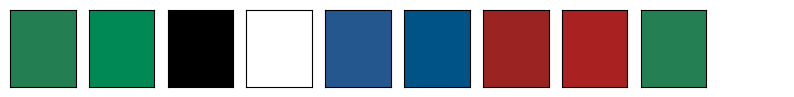

In [2]:
# Visualize all valid colors as 5x5 squares aligned. Sort them so that similar colors are closer

import matplotlib.pyplot as plt
def plot_colors(colors, cols):
	n = len(colors)
	rows = (n + cols - 1) // cols  # Calculate number of rows needed
	fig, ax = plt.subplots(rows, cols, figsize=(cols, rows), subplot_kw=dict(xticks=[], yticks=[]))
	
	# Handle case where there's only one row
	if rows == 1:
		ax = ax.reshape(1, -1)
	
	for i, color in enumerate(colors):
		ax[i // cols, i % cols].add_patch(plt.Rectangle((0, 0), 1, 1, color=np.array(color)/255))
	
	# Hide any unused subplots
	for j in range(i + 1, rows * cols):
		ax[j // cols, j % cols].axis('off')
	
	plt.show()

plot_colors(all_valid_colors, cols=10)

Cluster 0: [[35, 127, 82], [0, 136, 85], [36, 127, 82]]
Cluster 1: [[36, 87, 142], [0, 83, 135]]
Cluster 2: [[155, 36, 35], [169, 33, 33]]


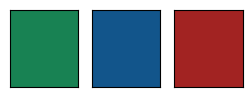

Average colors (rounded to closest intger)
[[ 24. 130.  83.]
 [ 18.  85. 138.]
 [162.  34.  34.]]


In [6]:

# Cluster colors using DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Convert colors to numpy array
colors_array = np.array(all_valid_colors)

# Standardize the colors
scaler = StandardScaler()
colors_scaled = scaler.fit_transform(colors_array)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)
clusters = dbscan.fit_predict(colors_scaled)

# Create a dictionary to hold clusters
color_clusters = {}
for color, cluster in zip(all_valid_colors, clusters):
	if cluster not in color_clusters:
		color_clusters[cluster] = []
	color_clusters[cluster].append(color)

# Print the clusters
for cluster, colors in color_clusters.items():
	if cluster != -1:  # Ignore noise points
		print(f"Cluster {cluster}: {colors}")

# Compute the average color for each cluster
average_colors = []
for cluster, colors in color_clusters.items():
	if cluster != -1:  # Ignore noise points
		average_color = np.mean(colors, axis=0)
		average_colors.append(average_color)

# Visualize the average colors
if len(average_colors) > 0:
	plot_colors(average_colors, cols=len(average_colors))

print("Average colors (rounded to closest intger)")
print(np.round(average_colors))

4.206704429243757e-17
0.11760473672008193
0.1933778569411435
0.02090357219649047
0.22016451865218
0.011165936266764665
0.19634589205622752


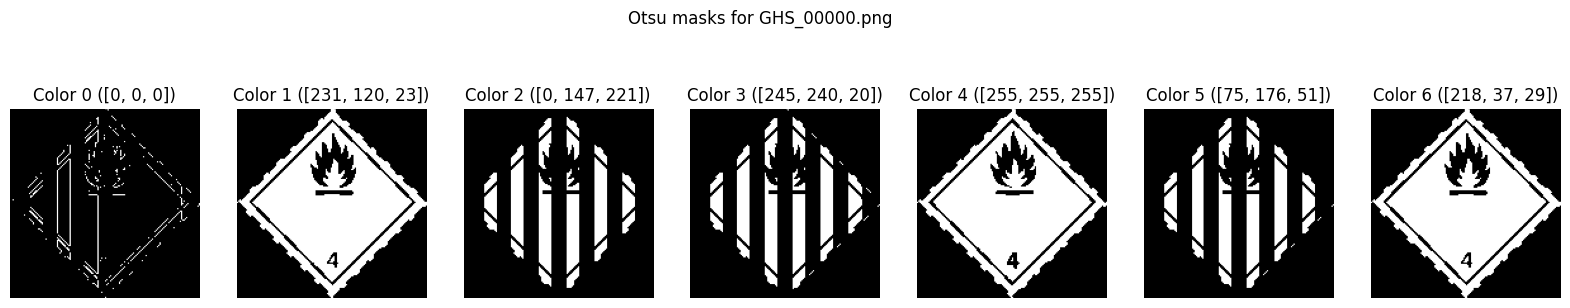

In [4]:
import cv2
from skimage.filters import threshold_otsu



for png_file in png_files:
	if "GHS_00000" not in png_file:
		continue

	img_rgb = np.array(cv2.imread(os.path.join(path, png_file), cv2.IMREAD_COLOR_RGB))
	
	h, w, _ = img_rgb.shape

	# Reshape image to (num_pixels, 3)
	pixels = img_rgb.reshape(-1, 3).astype(np.float64)

	# Build matrix of your reference colors (len_colors x 3)
	C = np.array(all_valid_colors).astype(np.float64)  

	# Compute least squares weights for all pixels
	# Each pixel p wants to solve C^T w = p
	# So we solve for w for each pixel
	weights = np.linalg.lstsq(C.T, pixels.T, rcond=None)[0].T  # shape (num_pixels, len_colors)

	# Optionally: Clip negatives to zero
	weights = np.clip(weights, 0, None)

	# Reshape weights to (h, w, len_colors)
	weights_img = weights.reshape(h, w, -1)

	# For plotting masks
	fig, axs = plt.subplots(1, len(all_valid_colors), figsize=(20, 4))
	fig.suptitle(f"Otsu masks for {png_file}")

	for i in range(len(all_valid_colors)):
		# Extract channel i
		channel = weights_img[:, :, i]

		# Otsu threshold
		thresh = threshold_otsu(channel)
		print(thresh)
		binary_mask = (channel > thresh).astype(np.uint8)

		axs[i].imshow(binary_mask, cmap='gray')
		axs[i].set_title(f"Color {i} ({all_valid_colors[i]})")
		axs[i].axis('off')

	plt.show()


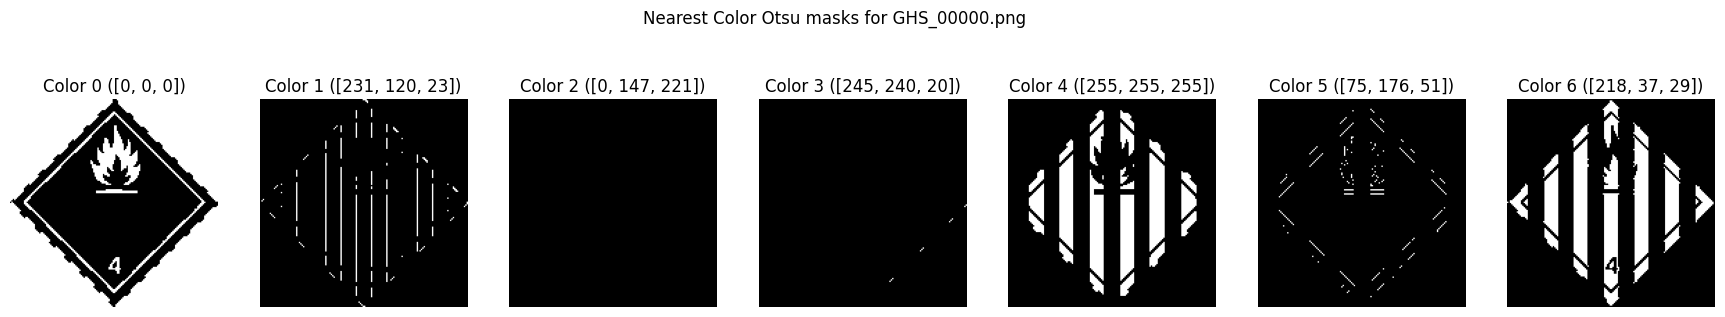

In [5]:
for png_file in png_files:
    if "GHS_00000" not in png_file:
        continue

    img_rgb = np.array(cv2.imread(os.path.join(path, png_file), cv2.IMREAD_COLOR))
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    pixels = img_rgb.reshape(-1, 3).astype(np.float64)
    C = np.array(all_valid_colors).astype(np.float64)
    len_colors = len(all_valid_colors)

    dists = np.linalg.norm(pixels[:, None, :] - C[None, :, :], axis=2)
    nearest_idx = np.argmin(dists, axis=1)
    weights_hard = np.eye(len_colors)[nearest_idx].reshape(h, w, len_colors)

    fig, axs = plt.subplots(1, len_colors, figsize=(22, 4))
    fig.suptitle(f"Nearest Color Otsu masks for {png_file}")

    for i in range(len_colors):
        channel = weights_hard[:, :, i]
        try:
            thresh = threshold_otsu(channel)
        except ValueError:
            thresh = np.max(channel) * 0.5
        binary_mask = (channel > 0.9).astype(np.uint8)

        axs[i].imshow(binary_mask, cmap='gray')
        axs[i].set_title(f"Color {i} ({all_valid_colors[i]})")
        axs[i].axis('off')

    plt.show()

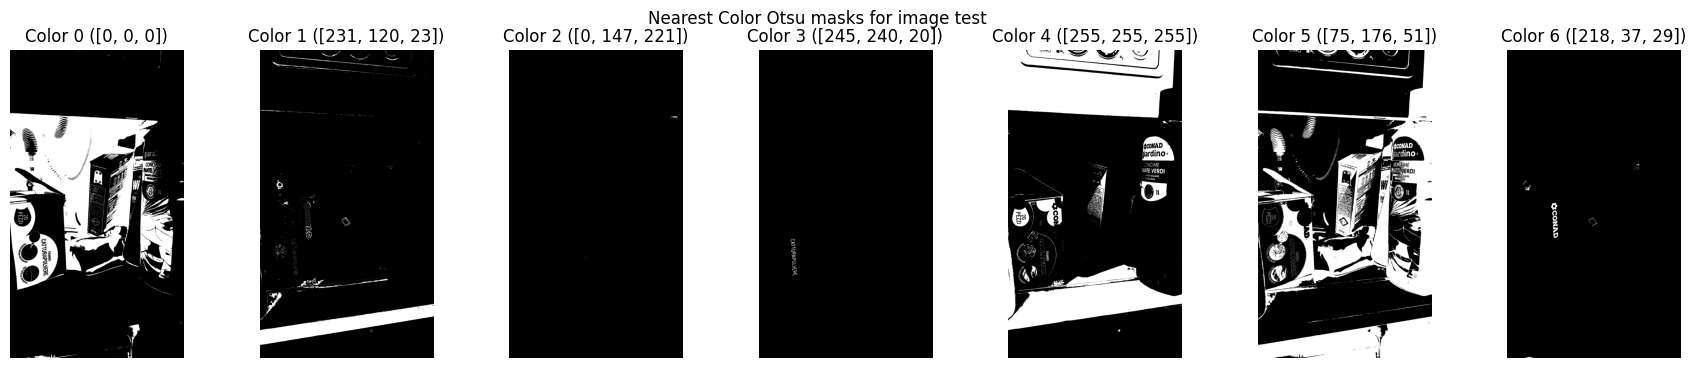

In [13]:
img_test = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00006.jpeg"
img_test = np.array(cv2.imread(img_test, cv2.IMREAD_COLOR))
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

pixels = img_test.reshape(-1, 3).astype(np.float64)
C = np.array(all_valid_colors).astype(np.float64)
len_colors = len(all_valid_colors)

h, w, _ = img_test.shape

dists = np.linalg.norm(pixels[:, None, :] - C[None, :, :], axis=2)
nearest_idx = np.argmin(dists, axis=1)
weights_hard = np.eye(len_colors)[nearest_idx].reshape(h, w, len_colors)

fig, axs = plt.subplots(1, len_colors, figsize=(22, 4))
fig.suptitle("Nearest Color Otsu masks for image test")

for i in range(len_colors):
	channel = weights_hard[:, :, i]
	try:
		thresh = threshold_otsu(channel)
	except ValueError:
		thresh = np.max(channel) * 0.5
	binary_mask = (channel > 0.9).astype(np.uint8)

	axs[i].imshow(binary_mask, cmap='gray')
	axs[i].set_title(f"Color {i} ({all_valid_colors[i]})")
	axs[i].axis('off')

plt.show()
